In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 1
USE_SAMPLE = SAMPLE_LEVEL == 1
USE_TOY_SAMPLE = SAMPLE_LEVEL == 2

FORCE_REWRITE = True#(ON_KAGGLE and SAMPLE_LEVEL == 0)

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')
    sys.path.append('.')

In [6]:
# from preprocessing import *
from src.metrics import *
# from src.preprocessing import process_train_data, process_test_data
from src.preprocessing.ingest_data import merge_asset_details
from src.cv import TimeSeriesSplit, get_date_range
from src.modeling import Evaluator
from src.metrics import compute_metrics

In [ ]:
def setup_env(on_kaggle: bool = True, sample_level: int = 0):
    if on_kaggle and sample_level == 0:
         raw_dir = Path('../input/g-research-crypto-forecasting/')
    elif on_kaggle and sample_level > 0:
        raw_dir = Path('../input/create-sample-dataset/data/raw/')
    else:
        raw_dir = Path('data/raw')
    
    if sample_level > 0:
        raw_dir = raw_dir.joinpath('sample', str(sample_level))

In [7]:
if ON_KAGGLE:
    RAW_DIR = Path('../input/g-research-crypto-forecasting/')
    SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/sample/')
    TOY_SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/toy_sample/')
else:
    RAW_DIR =  Path('data/raw')
    TOY_SAMPLE_DIR = RAW_DIR.joinpath('toy_sample')
    SAMPLE_DIR = RAW_DIR.joinpath('sample')

# filename
TRAIN_FILE = 'train.csv'
ASSET_DETAILS_PATH = RAW_DIR / 'asset_details.csv'

In [8]:
if USE_TOY_SAMPLE:
    print('USING TOY DATASET')
    RAW_TRAIN_PATH = TOY_SAMPLE_DIR / TRAIN_FILE

elif USE_SAMPLE:
    print('USING SAMPLE DATASET')
    RAW_TRAIN_PATH = SAMPLE_DIR / TRAIN_FILE

else:
    print('USING RAW DATASET')
    RAW_TRAIN_PATH = RAW_DIR / TRAIN_FILE

assert RAW_TRAIN_PATH.exists()

USING SAMPLE DATASET


In [9]:
!ls {RAW_DIR}

asset_details.csv		   sample
example_sample_submission.csv	   supplemental_train.csv
example_test.csv		   toy_sample
g-research-crypto-forecasting.zip  train.csv
gresearch_crypto


In [10]:
%%time 
raw_data = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 5.24 s, sys: 594 ms, total: 5.83 s
Wall time: 6.47 s


## create train set

In [11]:
PREPRO_PARAMS = {'window': 60}
MAIN_INDEX = ['timestamp', 'Asset_ID']

In [12]:
# get valid data only, drop where the target is NaN 
data = raw_data.dropna(subset=['Target'])
# format time to human readable 
data['time'] = pd.to_datetime(data['timestamp'], unit='s')
# merge asset names
data = merge_asset_details(data, ASSET_DETAILS_PATH)

/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
0,1609459260,3,104.0,0.181465,0.181702,0.181270,0.181493,6.134333e+05,0.181527,0.001255,2021-01-01 00:01:00,Cardano
1,1609459260,2,275.0,342.556667,343.500000,342.420000,342.966667,4.199310e+02,342.842188,-0.002884,2021-01-01 00:01:00,Bitcoin Cash
2,1609459260,0,219.0,37.385000,37.422100,37.348700,37.389000,2.749569e+03,37.387059,-0.001669,2021-01-01 00:01:00,Binance Coin
3,1609459260,1,4039.0,28985.511250,29086.900000,28960.000000,29032.387500,1.637870e+02,29017.664870,0.000396,2021-01-01 00:01:00,Bitcoin
4,1609459260,4,84.0,0.004671,0.004683,0.004668,0.004677,2.202482e+06,0.004675,-0.008679,2021-01-01 00:01:00,Dogecoin


In [14]:
data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
5298791,1632181440,9,163.0,156.502000,156.620000,156.000000,156.075667,7.381963e+02,156.260253,-0.001154,2021-09-20 23:44:00,Litecoin
5298792,1632181440,10,23.0,2420.146667,2421.000000,2412.779000,2414.069667,1.315794e+00,2417.326038,0.009831,2021-09-20 23:44:00,Maker
5298793,1632181440,13,512.0,0.090989,0.091133,0.090831,0.090885,1.900695e+06,0.090943,0.004163,2021-09-20 23:44:00,TRON
5298794,1632181440,12,193.0,0.280952,0.281300,0.280175,0.280403,1.628699e+05,0.280655,0.000449,2021-09-20 23:44:00,Stellar
5298795,1632181440,11,38.0,232.075000,232.300000,231.310000,231.680000,4.914804e+01,231.794078,0.002568,2021-09-20 23:44:00,Monero


In [15]:
from src.preprocessing.feature_gen import compute_instant_features
from src.preprocessing.ingest_data import infer_dtypes
from src.preprocessing import EXPECTED_RAW_COLS

In [16]:
data = infer_dtypes(data)

In [17]:
data = compute_instant_features(data)

In [18]:
data.head()

,timestamp,Asset_ID,Count,High,Low,Close,Volume,VWAP,Target,time,Asset_Name,high_low_return,open_close_return,upper_shadow,lower_shadow,dolar_amount,vol_per_trades
0,1609459260,3,104.0,1.001304,0.998924,0.181493,6.134333e+05,0.181527,0.001255,2021-01-01 00:01:00,Cardano,0.694338,0.693223,5.517041,0.181661,1.113339e+05,5898.397437
1,1609459260,2,275.0,1.002754,0.999601,342.966675,4.199310e+02,342.842194,-0.002884,2021-01-01 00:01:00,Bitcoin Cash,0.694723,0.693745,0.002924,342.693390,1.440223e+05,1.527022
2,1609459260,0,219.0,1.000992,0.999029,37.389000,2.749569e+03,37.387058,-0.001669,2021-01-01 00:01:00,Binance Coin,0.694129,0.693201,0.026772,37.421329,1.028036e+05,12.555111
3,1609459260,1,4039.0,1.003498,0.999120,29032.386719,1.637870e+02,29017.664062,0.000396,2021-01-01 00:01:00,Bitcoin,0.695336,0.693955,0.000035,29011.046875,4.755129e+06,0.040551
4,1609459260,4,84.0,1.002655,0.999443,0.004677,2.202482e+06,0.004675,-0.008679,2021-01-01 00:01:00,Dogecoin,0.694753,0.693843,214.375336,0.004673,1.030123e+04,26220.028831


In [19]:
list(data.columns)

['timestamp',
 'Asset_ID',
 'Count',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'Target',
 'time',
 'Asset_Name',
 'high_low_return',
 'open_close_return',
 'upper_shadow',
 'lower_shadow',
 'dolar_amount',
 'vol_per_trades']

In [20]:
FEATURES = [
'Count',
'High',
'Low',
'Close',
'Volume',
'VWAP',
'high_low_return',
'open_close_return',
'upper_shadow',
'lower_shadow',
'dolar_amount',
'vol_per_trades'
]

In [21]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List


class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self,
                 features: List[str] = None,
                 sort: bool = False):
        self.sort = sort
        self.features = features[:]
        if self.sort:
            self.features.sort()
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame):
        return X.loc[:, self.features]

    
def test_filter_features():
    n_feat = 100
    size = 500
    t = 100
    expected_columns = [f'{f}_ft' for f in np.arange(n_feat)]
    
    expected_df = pd.DataFrame(np.random.randn(size, n_feat), columns=expected_columns)
    tmf = FilterFeatures(expected_columns)
    tmf.fit(expected_df)
    
    for i in range(t):
        shuffle_columns = np.random.permutation(expected_columns)
        shuffle_df = expected_df.loc[:, shuffle_columns]
        actual_columns = list(tmf.transform(shuffle_df).columns)
        assert (actual_columns == expected_columns), f'cols do not match at iter {i}'
    
test_filter_features()

def build_model(params={'alpha': 0.001}):
    model = Pipeline([('filter', FilterFeatures(FEATURES)),
                      ('norm', MinMaxScaler()),
                      ('model', Ridge(params['alpha']))])
    return model

In [22]:
def train_model(config, train_data, valid_data, pipeline=None):
    model  = build_model(config['model'])

    if config['training']['time_decay_alpha'] is not None:
        time_decay_alpha = config['training']['time_decay_alpha']
        print(f'using exponential_time_decay with alpha {time_decay_alpha}')
        timesteps = ((train_data['timestamp'].max() - train_data['timestamp'])//60//60//24)
        weight = time_decay_alpha ** timesteps
    else:
        weight = None

    model.fit(train_data[FEATURES], train_data['Target'], model__sample_weight=weight)
    return model


def get_mask_for_asset(data: pd.DataFrame, asset_id: int):
    return (data['Asset_ID'] == asset_id)


def get_data_for_asset(data: pd.DataFrame, asset_id: int):
    mask = get_mask_for_asset(data, asset_id)
    return data.loc[mask, :].reset_index(drop=True), mask

In [23]:
PULIC_LB_RANGE = ['2021-06-13 00:00:00',
                  '2021-09-13 00:00:00'] # 3 MONTH WORTH OF DATA

if USE_TOY_SAMPLE:
    EVAL_PERIODS = [['2021-09-15', '2021-09-22']]

else:
    EVAL_PERIODS = [PULIC_LB_RANGE]

In [24]:
CV_PARAMS = {'gap_unit': 'min', 'dt_col': 'time'}

CV = TimeSeriesSplit(EVAL_PERIODS, **CV_PARAMS)

In [25]:
train_idx, valid_idx = next(iter(CV.split(data)))

In [26]:
train_data = data.loc[train_idx, :].reset_index(drop=True)

In [27]:
valid_data = data.loc[valid_idx, :].reset_index(drop=True)

In [28]:
get_date_range(train_data['time'])

min   2021-01-01 00:01:00
max   2021-06-12 23:59:00
Name: time, dtype: datetime64[ns]

In [29]:
get_date_range(valid_data['time'])

min   2021-06-13
max   2021-09-13
Name: time, dtype: datetime64[ns]

In [30]:
MODEL_CONFIG = {'alpha': 0.001}
TRAIN_CONFIG = {'time_decay_alpha': 0.99}
CONFIG = {'model': MODEL_CONFIG, 'training': TRAIN_CONFIG}

In [31]:
valid_yhat = np.zeros(len(valid_data))
MODELS = {}
for asset_id, train_asset_data in data.groupby("Asset_ID"):
    print(f'training model for asset_ID == {asset_id}')
    train_asset_data = train_asset_data.reset_index(drop=True)
    valid_mask = (valid_data['Asset_ID'] == asset_id)
    valid_asset_data = valid_data.loc[valid_mask, :].reset_index(drop=True)
    
    
    model = train_model(CONFIG, train_asset_data, valid_asset_data)
    MODELS[asset_id] = model
    valid_yhat[valid_mask] = model.predict(valid_asset_data)

training model for asset_ID == 0
using exponential_time_decay with alpha 0.99
training model for asset_ID == 1
using exponential_time_decay with alpha 0.99
training model for asset_ID == 2
using exponential_time_decay with alpha 0.99
training model for asset_ID == 3
using exponential_time_decay with alpha 0.99
training model for asset_ID == 4
using exponential_time_decay with alpha 0.99
training model for asset_ID == 5
using exponential_time_decay with alpha 0.99
training model for asset_ID == 6
using exponential_time_decay with alpha 0.99
training model for asset_ID == 7
using exponential_time_decay with alpha 0.99
training model for asset_ID == 8
using exponential_time_decay with alpha 0.99
training model for asset_ID == 9
using exponential_time_decay with alpha 0.99
training model for asset_ID == 10
using exponential_time_decay with alpha 0.99
training model for asset_ID == 11
using exponential_time_decay with alpha 0.99
training model for asset_ID == 12
using exponential_time_decay

In [84]:
valid_data['yhat'] = valid_yhat

In [107]:
scores, corrs = compute_metrics(valid_data)

In [108]:
scores

theor_corr             0.034376
weighted_corr          0.033282
crypto_consistency    13.000000
sharpe                 1.459421
corr_period_mean       0.033190
consistency            1.000000
corr_period_std        0.022742
min_period_corr        0.005145
corr_min              -0.001999
corr_max               0.066544
corr_std               0.021524
dtype: float64

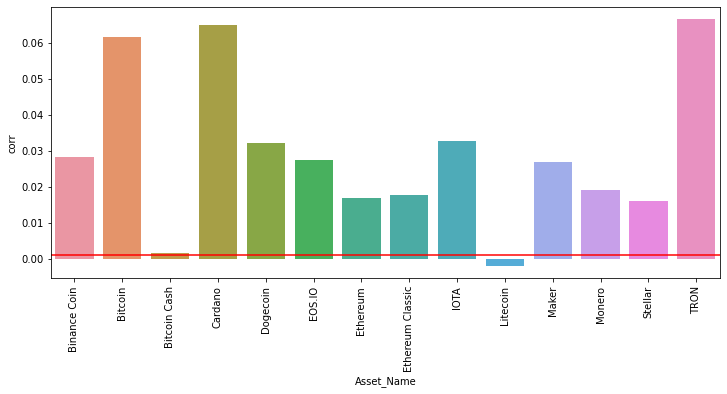

In [109]:
plt.figure(figsize=(12, 5))
sns.barplot(x='Asset_Name', y='corr', data=corrs)
plt.xticks(rotation=90);
plt.axhline(0.001, color='red')

In [78]:
def _create_fi_pd(features, importances):
    return (pd.DataFrame({'feature': features, 'importance': importances})
            .sort_values(by=['importance']).reset_index(drop=True))

def compute_fi(pipeline):
    return _create_fi_pd(pipeline['filter'].features, pipeline['model'].coef_)

In [79]:
fi = pd.concat([compute_fi(model).assign(Asset_ID=asset) for asset, model in MODELS.items()])

In [80]:
fi_stats = fi.groupby('feature')['importance'].describe()
fi_stats['abs_mean'] = fi_stats['mean'].abs()
fi_stats = fi_stats.sort_values(by='abs_mean', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

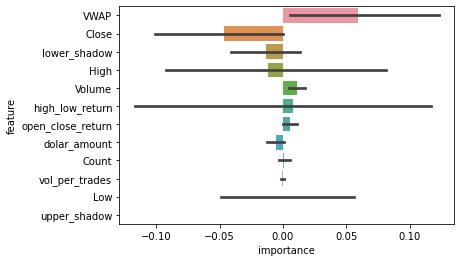

In [81]:
sns.barplot(data=fi, y='feature', x='importance', order=fi_stats.index)

In [45]:
def add_kaggle_index_columns(data: pd.DataFrame):
    data['row_id'] = list(range(len(data)))
    data['row_id'] = data['row_id'].astype(np.int32)
    group_num = data[['timestamp']].drop_duplicates().sort_values(by='timestamp')
    group_num['group_num'] = list(range(len(group_num)))
    data = data.merge(group_num, on='timestamp', how='left')
    assert data['group_num'].isna().sum() == 0
    return data
    
    
EXPECTED_RAW_COLS = ['timestamp', 'Asset_ID', 'Count',
                     'Open', 'High', 'Low', 'Close',
                     'Volume', 'VWAP']

def simulate_kaggle_api(data: pd.DataFrame):
    copy_data = data.copy()
    data = add_kaggle_index_columns(copy_data)
    
    for group_id, group_data in data.groupby('group_num'):
        group_data = group_data.reset_index(drop=True)
        submission = group_data.loc[:, ['row_id', 'Target']]
        yield group_data.loc[:, EXPECTED_RAW_COLS + ['row_id']], submission


In [46]:
raw_test_mask = raw_data['timestamp'].between(valid_data['timestamp'].min(), valid_data['timestamp'].max())
raw_test_df_iter = raw_data[raw_test_mask].reset_index(drop=True)
assert np.allclose(raw_test_df_iter['Target'].dropna(), valid_data['Target'])

In [47]:
raw_test_df_iter['timestamp'].min()

1631664000

In [48]:
test_iter = simulate_kaggle_api(raw_test_df_iter)

In [49]:
from src.preprocessing import inference
import time
import sys

In [50]:
actual_submission = []
elapsed_times = []
i = 0
for raw_test_df, submission in test_iter:
    print('{} days'.format(i/(24 * 60)), end='\r')
    start_inference_time = time.time()
    submission = inference(test_data=raw_test_df, submission=submission,
                            models=MODELS)
    inference_elapsed_time = time.time() - start_inference_time 
    elapsed_times.append(inference_elapsed_time)
    actual_submission.append(submission)
    i+=1
    sys.stdout.flush()

In [51]:
actual_submission_df = pd.concat(actual_submission, ignore_index=True)

In [52]:
index_template = raw_test_df_iter[['timestamp', 'Asset_ID']].assign(row_id=np.arange(len(raw_test_df_iter)))

In [53]:
actual_submission_df = index_template.merge(actual_submission_df, on=['row_id'], how='left')

In [54]:
yhat_test = valid_data[['timestamp', 'Asset_ID', 'yhat']].merge(actual_submission_df, on=['timestamp', 'Asset_ID'], how='left')
yhat_test = yhat_test.dropna()

In [55]:
error = (yhat_test['yhat'] -  yhat_test['Target']) / yhat_test['yhat']
error.abs().max()

2.0673221387150413e-07

In [56]:
np.allclose(yhat_test['yhat'], yhat_test['Target'])

True

In [57]:
np.mean(elapsed_times), np.max(elapsed_times)

(0.06107479883276898, 0.21312308311462402)

In [58]:
np.sum(elapsed_times) / 60

8.77950233221054

In [68]:
days = 90
total = 0.06107479883276898 * (days * 24 * 60)
total / 60 / 60

2.1986927579796833